Combining all datasets to one dataset to easyly use ML methods

In [27]:
import pandas as pd

# upload the datasets
crashes = pd.read_csv("NYC Vehicle Crashes 2012 - 2023.csv", usecols=['CRASH DATE'], parse_dates=['CRASH DATE'])
weather_2019 = pd.read_csv("nyc_temperature.csv", usecols=['date', 'tavg', 'precipitation'])
weather_2020_2021 = pd.read_csv("NYC_Weather_2016_2022.csv", usecols=['time', 'temperature_2m (°C)', 'precipitation (mm)'])

# filtering crash data
crashes = crashes[(crashes['CRASH DATE'] >= '2019-01-01') & (crashes['CRASH DATE'] <= '2021-12-31')]
crash_counts = crashes.groupby('CRASH DATE').size().reset_index(name='num_crashes')

# 2019 weather data
weather_2019['date'] = pd.to_datetime(weather_2019['date'], format='%d/%m/%Y', errors='coerce')
weather_2019['tavg'] = pd.to_numeric(weather_2019['tavg'], errors='coerce')
weather_2019['precipitation'] = pd.to_numeric(weather_2019['precipitation'], errors='coerce')
weather_2019_daily = weather_2019.groupby('date')[['tavg', 'precipitation']].mean().reset_index()

# 2020–2021 weather data
weather_2020_2021['time'] = pd.to_datetime(weather_2020_2021['time'], errors='coerce')
weather_2020_2021 = weather_2020_2021[
    (weather_2020_2021['time'] >= '2020-01-01') & (weather_2020_2021['time'] <= '2021-12-31')
]
weather_2020_2021.rename(columns={
    'temperature_2m (°C)': 'tavg',
    'precipitation (mm)': 'precipitation'
}, inplace=True)
weather_2020_2021['date'] = pd.to_datetime(weather_2020_2021['time'].dt.date)
weather_2020_2021['tavg'] = pd.to_numeric(weather_2020_2021['tavg'], errors='coerce')
weather_2020_2021['precipitation'] = pd.to_numeric(weather_2020_2021['precipitation'], errors='coerce')
weather_2020_2021_daily = weather_2020_2021.groupby('date')[['tavg', 'precipitation']].mean().reset_index()

# combining weather data
weather_combined = pd.concat([weather_2019_daily, weather_2020_2021_daily], ignore_index=True)

# combining crash and weather data
final_df = pd.merge(crash_counts, weather_combined, left_on='CRASH DATE', right_on='date', how='left')
final_df.fillna(final_df.mean(numeric_only=True), inplace=True)
final_df.drop(columns=['date'], inplace=True)
final_df.dropna(inplace=True)

# data enrichment
final_df['bad_weather'] = ((final_df['precipitation'] > 3) | (final_df['tavg'] < 0)).astype(int)
final_df['temp_category'] = final_df['tavg'].apply(
    lambda temp: 'Very Cold' if temp < 0 else ('Cold' if temp < 10 else ('Mild' if temp < 20 else 'Warm'))
)
final_df['is_weekend'] = final_df['CRASH DATE'].dt.weekday.isin([5, 6]).astype(int)

# saving the final document to use ML methods later
final_df.to_csv("final_df_minimized.csv", index=False)


ML Modeling with Visualizations

In [28]:
# ML Modeling with Visualizations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


Load the prepared dataset

In [29]:
final_df = pd.read_csv("final_df_minimized.csv")

Feature matices and defining fetaures

In [30]:
# Define feature matrix X and target variable y
X = final_df[['precipitation', 'tavg', 'is_weekend', 'bad_weather', 'temp_category']]
y = final_df['num_crashes']

# Define numeric and categorical features for preprocessing
numeric_features = ['precipitation', 'tavg']
categorical_features = ['is_weekend', 'bad_weather', 'temp_category']

# ColumnTransformer to scale numeric features and encode categorical ones
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])


ML Models

In [31]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining machine learning models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = []  # To store performance metrics

Training Models and visualization

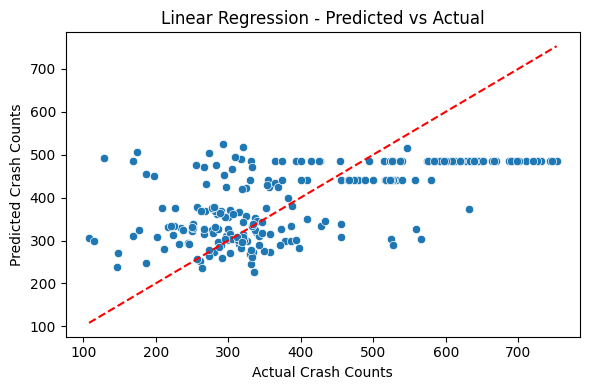

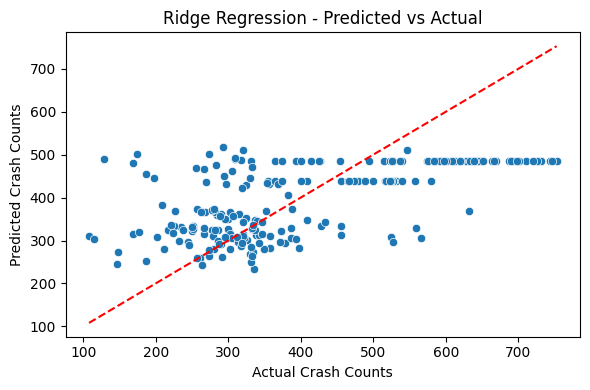

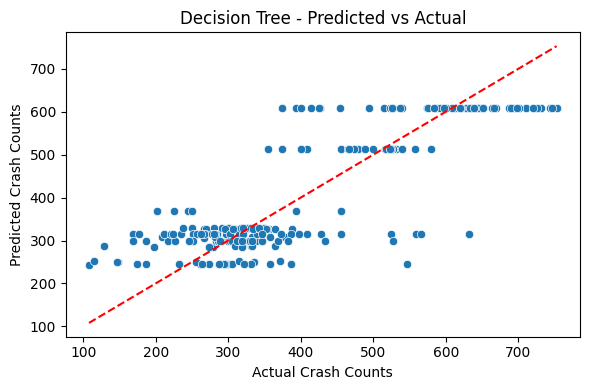

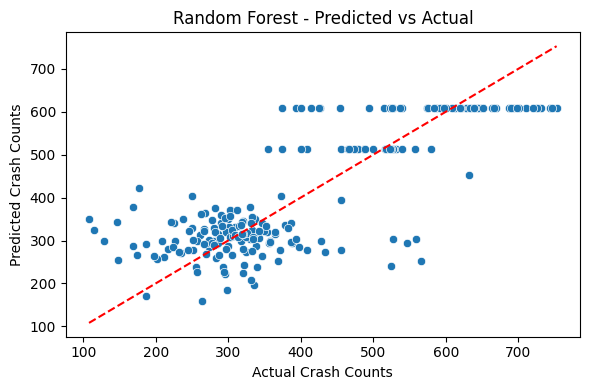

In [32]:
# Training each model, evaluate performances and ploting

for name, model in models.items():
    # Create pipeline
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2})

    # Visualization: Predicted vs Actual
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Crash Counts")
    plt.ylabel("Predicted Crash Counts")
    plt.title(f"{name} - Predicted vs Actual")
    plt.tight_layout()
    plt.show()


Feature Importance Testing

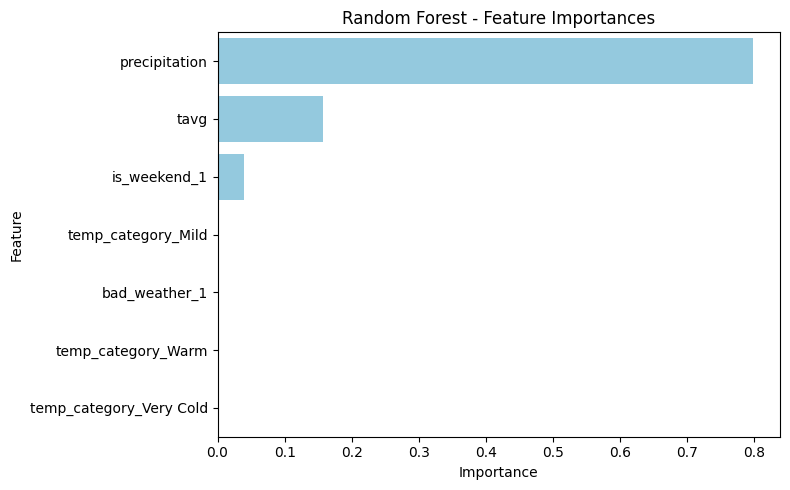

In [33]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pipe = Pipeline([('preprocessor', preprocessor), ('model', rf_model)])
rf_pipe.fit(X_train, y_train)

# Extract feature names
ohe = rf_pipe.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(encoded_cat_names)

# Getting importances
importances = rf_pipe.named_steps['model'].feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Ploting
plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', color='skyblue')
plt.title("Random Forest - Feature Importances")
plt.tight_layout()
plt.show()

Tree Visualization

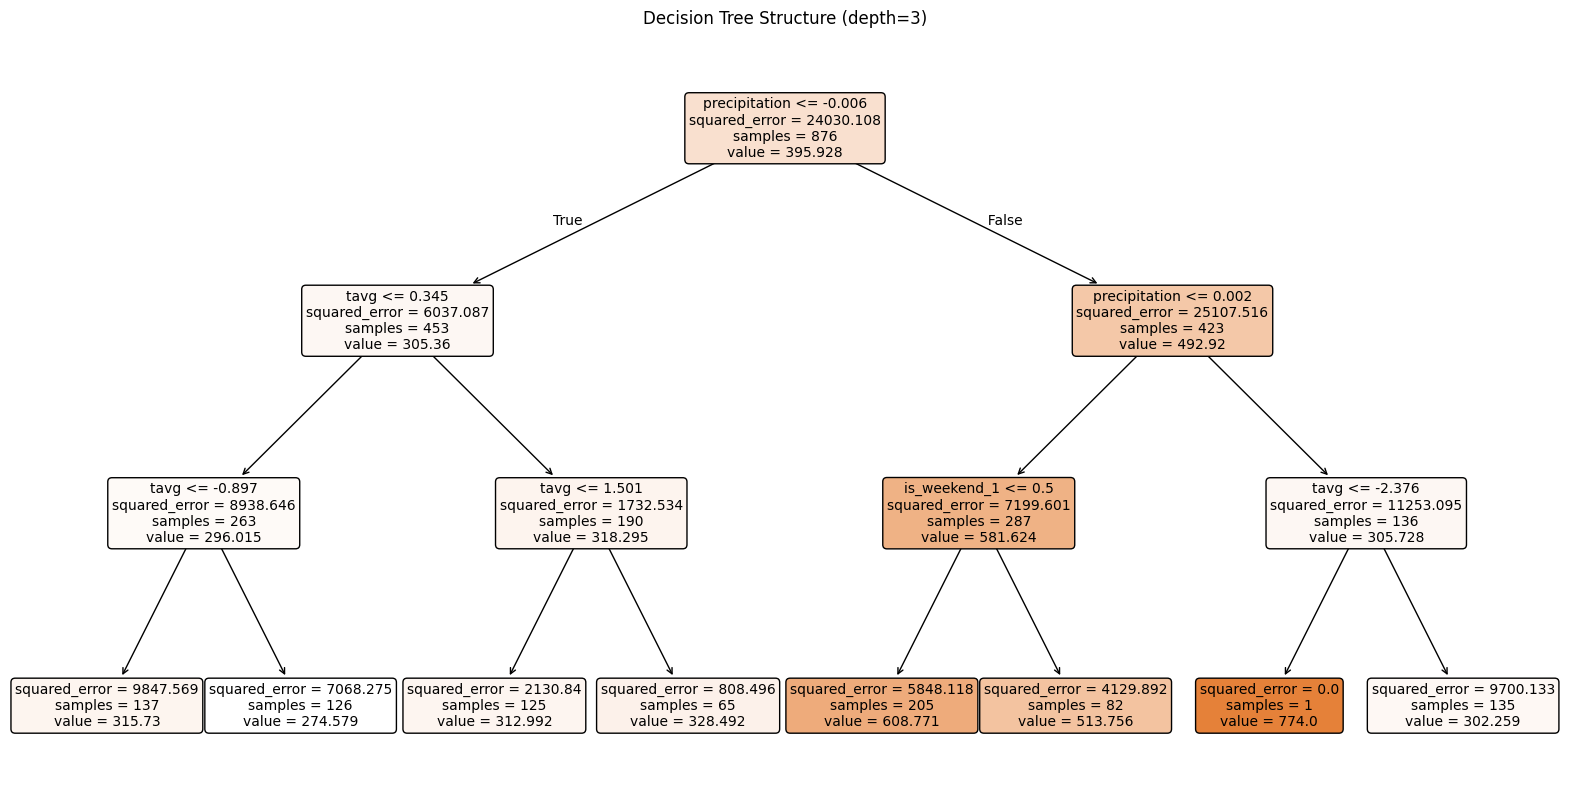

In [34]:
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_pipe = Pipeline([('preprocessor', preprocessor), ('model', tree_model)])
tree_pipe.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(tree_pipe.named_steps['model'], feature_names=feature_names, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Structure (depth=3)")
plt.show()

Summary

In [35]:
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df.sort_values(by='RMSE'))


Model Performance Summary:
               Model        RMSE        MAE        R²
2      Decision Tree   85.399942  62.685622  0.698010
3      Random Forest   90.878461  67.258663  0.658021
1   Ridge Regression  123.293043  98.141379  0.370559
0  Linear Regression  123.480897  98.369509  0.368640
